<a href="https://colab.research.google.com/github/OkoksNeDam/computer-vision-models-analysis/blob/main/classification-models/TwoLayerFCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training two-layer fully connected network for cifar10

## Load data

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:03<00:00, 49154276.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Split dataset and define dataloaders

In [3]:
torch.manual_seed(42)

TRAIN_SIZE = 40_000
VAL_SIZE = 10_000
TEST_SIZE = 10_000

BATCH_SIZE = 32
NUM_WORKERS = 2

train, val, _ = torch.utils.data.random_split(train_set, [TRAIN_SIZE, VAL_SIZE, len(train_set) - (TRAIN_SIZE + VAL_SIZE)])
test, _ = torch.utils.data.random_split(test_set, [TEST_SIZE, len(test_set) - TEST_SIZE])

train_dataloader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader = torch.utils.data.DataLoader(
    test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

val_dataloader = torch.utils.data.DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

## Visualize dataset

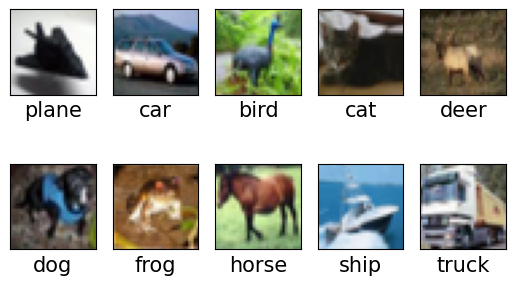

In [4]:
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5)
plt.subplots_adjust(top = 0.7)
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i].reshape((32,32,3)))
    i += 1

## Function for loss and accuracy visualization

In [5]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

## Implement neural network

In [6]:
class TwoLayerFCN(nn.Module):
    def __init__(self, in_features, hidden_size, num_classes, activation_fn, dropout=0.25):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(in_features = in_features, out_features = hidden_size),
            activation_fn,
            nn.Dropout(dropout),
            nn.Linear(in_features = hidden_size, out_features = num_classes)
        )
    def forward(self, X):
        return self.model(X)

## Learning cycle

In [7]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler=None, n_epochs=5):
    torch.manual_seed(42)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_model = None
    best_accuracy = 0.0

    for epoch in range(n_epochs):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for imgs, labels in tqdm(train_loader, desc='Training'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            train_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        val_loss, val_accuracy = 0.0, 0.0
        model.eval()
        for imgs, labels in tqdm(val_loader, desc='Validating'):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

        val_loss /= len(val_loader)

        if scheduler is not None:
            scheduler.step(val_loss)

        val_accuracy /= len(val_loader.dataset)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    return torch.min(torch.tensor(val_losses)).item(), best_accuracy, best_model

## Tuning hyperparameters

Let's find best learning rate

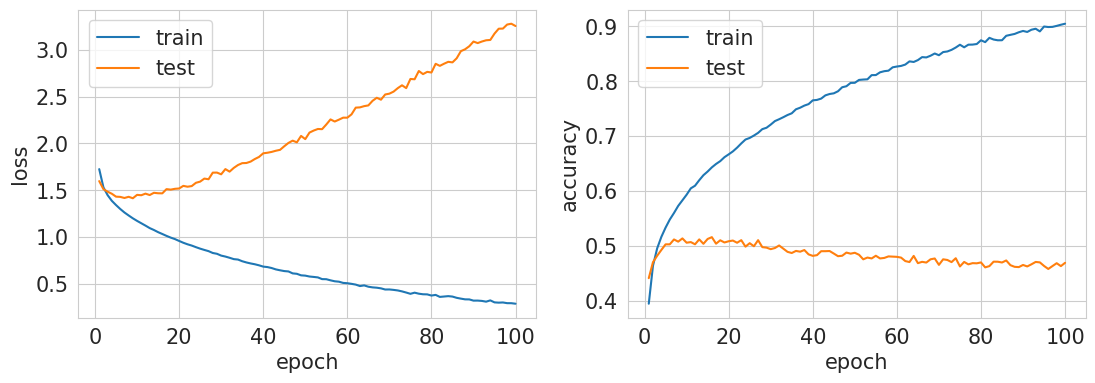

In [ ]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 100
dropout = 0
momentum = 0.9
lr = 1e-3

activation_fn = nn.ReLU()
model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.4153972864151, best val accuracy: 0.5157


It can be seen that with such a learning rate, the model almost immediately (after 5-7 epochs) begins to overfit, let's try to decrease this parameter to $lr = 1e-4$.

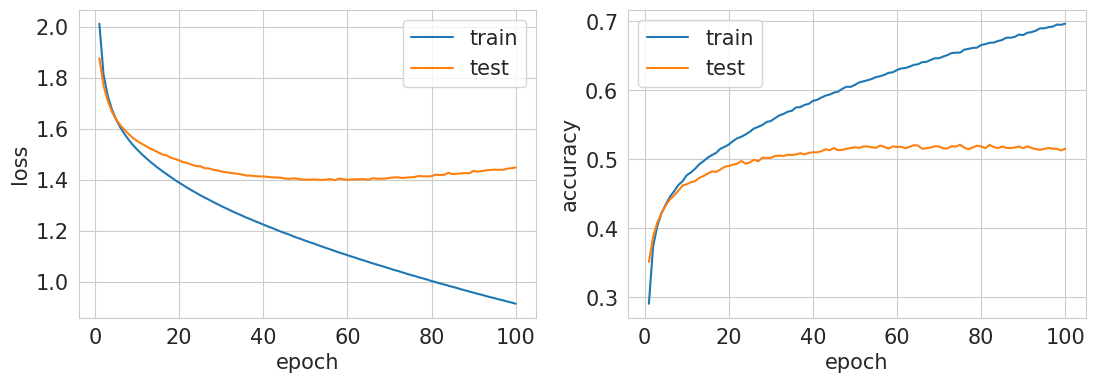

In [ ]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 100
dropout = 0
momentum = 0.9
lr = 1e-4

activation_fn = nn.ReLU()
model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.398230791091919, best val accuracy: 0.5213


It turned out better, loss dropped and accuracy increased. After epoch 50, the loss on validation stops falling and the model begins to overfit. Maybe we should make the learning rate even lower?

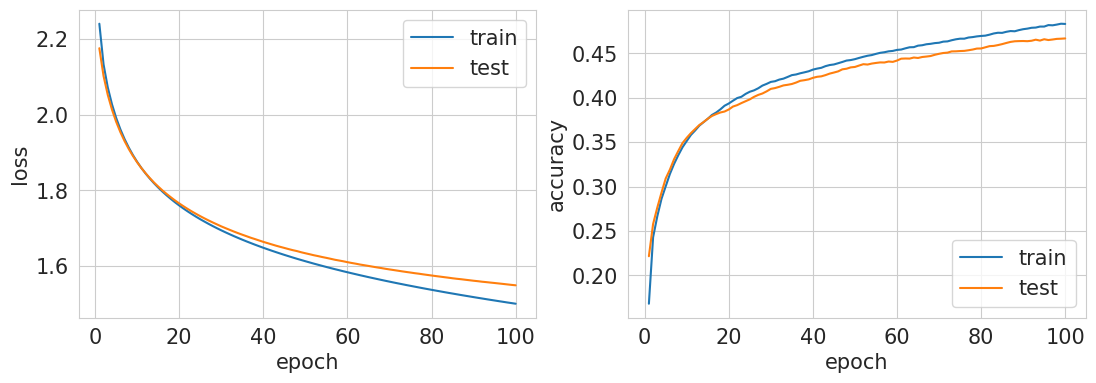

In [ ]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 100
dropout = 0
momentum = 0.9
lr = 1e-5

activation_fn = nn.ReLU()
model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.5486812591552734, best val accuracy: 0.4668


It was possible to continue training further, but the graph shows that the loss on validation began to plateau. Therefore, we conclude that the best constant $lr$ is the value $1e-4$ with accuracy $0.5213$.<br>
In the previous steps we chose a constant learning rate, let's try to use some lr scheduler methods.

ReduceLROnPlateau:

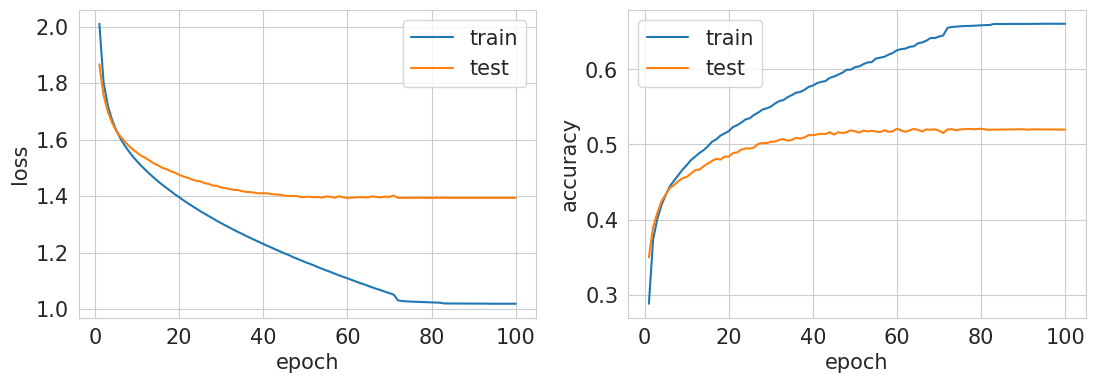

In [ ]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 100
dropout = 0
momentum = 0.9
lr = 1e-4

activation_fn = nn.ReLU()
model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.3932173252105713, best val accuracy: 0.521


The quality has not improved, let's try another scheduler.<br>
StepLR:

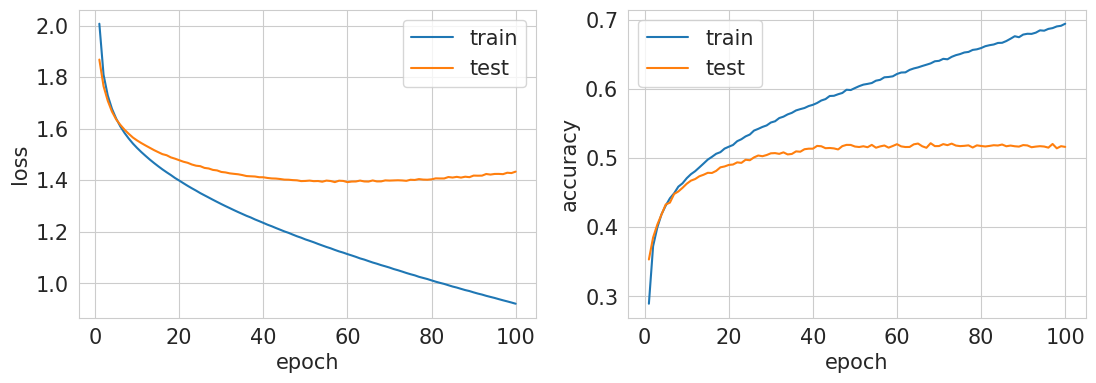

In [ ]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 100
dropout = 0
momentum = 0.9
lr = 1e-4

activation_fn = nn.ReLU()
model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, n_epochs=NUM_EPOCHS)

In [ ]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.3925182819366455, best val accuracy: 0.5214


We can conclude that for such a simple model and for such data,<br>
 using lr scheduler is practically useless, so we use a constant value $lr = 1e-4$.<br>
 Now we will try to add <b>dropout</b>, because this model is very easy to overfit.<br>
 We will also increase the number of epochs to 150, because, most likely, after 100 epochs the model will still continue to learn

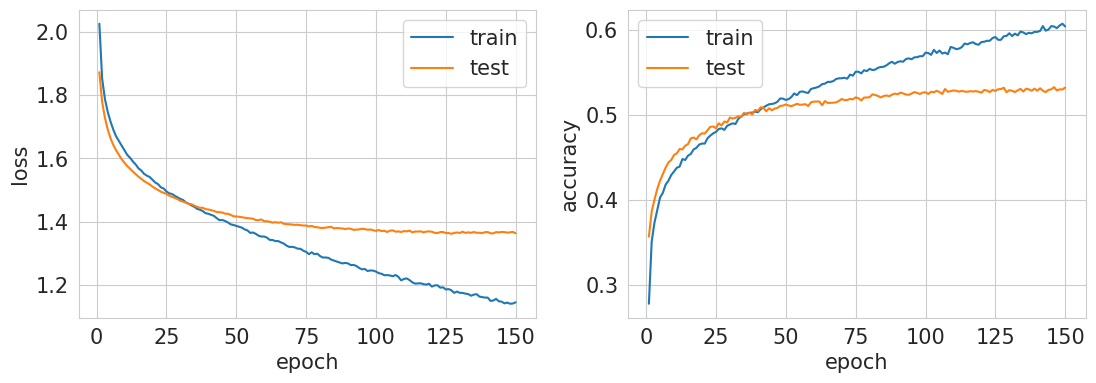

In [22]:
IMG_SIZE = 32 * 32 * 3
HIDDEN_SIZE = 100
NUM_EPOCHS = 150
dropout = 0.3
momentum = 0.9
lr = 1e-4
activation_fn = nn.ReLU()

model = TwoLayerFCN(in_features=IMG_SIZE, hidden_size=HIDDEN_SIZE, num_classes=len(classes), activation_fn=activation_fn, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=lr)
best_val_loss, best_val_accuracy, best_model = train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=NUM_EPOCHS)

In [23]:
print(f'best val loss: {best_val_loss}, best val accuracy: {best_val_accuracy}')

best val loss: 1.3616300821304321, best val accuracy: 0.5324


# Estimate model on test data.

In [27]:
test_loss, test_accuracy = 0.0, 0.0

best_model.eval()
for imgs, labels in tqdm(test_dataloader, desc='Testing'):
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = best_model(imgs)
        loss = criterion(logits, labels)

    test_loss += loss.item()
    test_accuracy += torch.sum(torch.argmax(logits.cpu(), dim=1) == labels.cpu()).item()

test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader.dataset)
test_loss, test_accuracy

Testing: 100%|██████████| 313/313 [00:03<00:00, 81.80it/s] 


(1.3747251005218433, 0.5175)